# Gearbox

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
s1, s2, s3, s4 = ?

while(t < T):

    v = update_v

    if gear == 1 and v >= s1 {
        gear = 0, nxt = 2, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif gear == 2 and v >= s2 {
        gear = 0, nxt = 3, w=0.8;
    } elif w < 0 and gear == 0 {
        gear = nxt;
    }

    w = w - 0.1;
```

Velocity evolves according to:
$$ \frac{d \textit{v}}{dt} = \begin{cases} v \cdot \alpha(i, v) + \textit{gauss}(5., 1.) & \text{if gear==i} \\
                                        -0.0005 v^2 + \textit{gauss}(0., 0.5) & \text{if gear==0}  \end{cases} $$

where $\alpha(i,v) = \frac{1}{1 + \frac{(v-p_i)^2}{25}}$ and $p_i = (5, 15, 25, 40, 60)$.

In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

### Original Model

In [2]:
# Cerchiamo un'approssimazione ragionevole per alpha

#import matplotlib.pyplot as plt
#
#lb = [0, 10, 20, 30, 50]
#ub = [10, 20, 30, 50, 100]
#p = [5,15, 25, 40, 60]
#
#for i in range(5):
#    v = np.linspace(lb[i], ub[i], 100)
#    y = [1/(1+(vi - p[i])**2/25) for vi in v]
#    
#    print('Average alpha {}: '.format(i+1), np.mean(y))

In [3]:
def orig_model(T=20, init_v=5., gear=1, s1=10, s2=20):
    
    traj = torch.zeros(T)
    traj[0] = init_v
    #noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))

    w = 0.
    p = [5,15, 25, 40, 60]
    s = [s1, s2]
    alpha = [0.78, 0.78, 0.78, 0.55, 0.25]
    
    for i in range(1,T):
        
        #update velocity
        if gear >= 1:
            traj[i] = traj[i-1] + 0.1*traj[i-1]*alpha[gear-1] + 0.1*distributions.Normal(5., 1.).rsample() 
        else:
            traj[i] = traj[i-1] - 0.1*0.0005*traj[i-1]**2 + distributions.Normal(0., 1.).rsample() 

        # update gear
        if gear >= 1 and gear < 3 and traj[i] > s[gear-1]:
            nxt = gear + 1
            gear = 0
            w = 0.3
        elif gear == 0 and w < 0:
            gear = nxt

        w = w - 0.1            
            
    return traj        

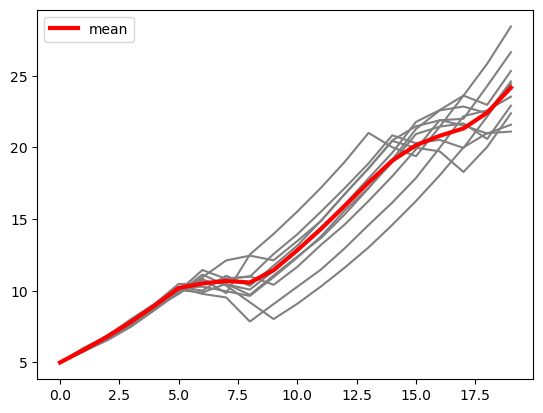

In [4]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

traj_set = []
for _ in range(50):
    traj_set.append(orig_model())
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(20), traj_set[i], color='grey')

plt.plot(range(20), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

### SOGA program

In [5]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [6]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Gearbox.soga')
cfg = produce_cfg(compiledFile)

pars = {'s1':8., 's2':25.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

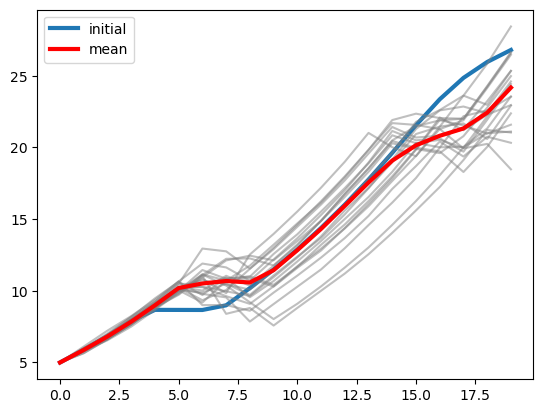

In [7]:
import matplotlib.pyplot as plt

y_init = output_dist.gm.mean()[:20].detach()
plt.plot(range(20), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(20):
    plt.plot(range(20), traj_set[i], color='grey', alpha=0.5)

plt.plot(range(20), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [8]:
torch.set_default_dtype(torch.float64)

In [9]:
def neg_log_likelihood(traj_set, dist):
    idx = list(range(1,20))
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = list(range(1,20))
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist)

tensor(inf, grad_fn=<NegBackward0>)

In [10]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

start = time()

for i in range(200):
    
    optimizer.zero_grad()  # Reset gradients
    
    #with torch.autograd.set_detect_anomaly(True):
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_log_likelihood(traj_set, current_dist)
        
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 20 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

end=time()

print('Optimization performed in ', round(end-start, 3))

s1: 8.050000190734863 s2: 24.950000762939453  loss: 6355.045836156281
s1: 8.929250717163086 s2: 23.95212173461914  loss: 1947.908212996472
s1: 9.367236137390137 s2: 23.043973922729492  loss: 961.924721691501
s1: 9.814247131347656 s2: 22.26570701599121  loss: 109.03797202389303
s1: 10.003839492797852 s2: 21.610944747924805  loss: 4.311912447349092
s1: 10.038275718688965 s2: 21.073713302612305  loss: -44.310593627816935
s1: 10.030195236206055 s2: 20.64391326904297  loss: -72.67716347042847
s1: 10.018794059753418 s2: 20.31710433959961  loss: -87.55088689386346
s1: 10.012532234191895 s2: 20.088590621948242  loss: -94.04098123605151
s1: 10.010130882263184 s2: 19.94658660888672  loss: -96.25616891978007
Optimization performed in  1708.269


In [11]:
params_dict

{'s1': tensor(10.0093, dtype=torch.float32, requires_grad=True),
 's2': tensor(19.8733, dtype=torch.float32, requires_grad=True)}

In [12]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Gearbox.soga')
cfg = produce_cfg(compiledFile)
output_dist = start_SOGA(cfg, params_dict)

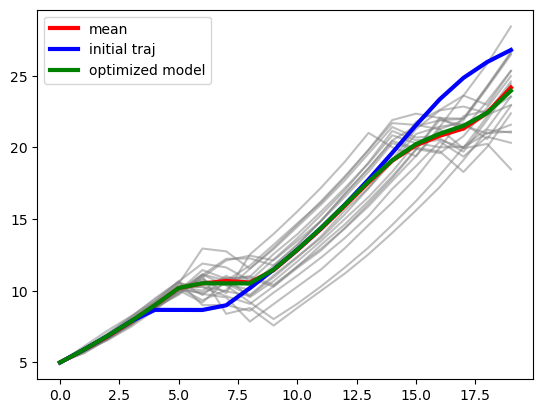

In [13]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(20):
    plt.plot(range(20), traj_set[i], color='grey', alpha=0.5)

plt.plot(range(20), torch.mean(traj_set, 0), lw=3, color='red', label='mean')

plt.plot(range(20), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(20), output_dist.gm.mean()[:20].detach(), lw=3, color='green', label='optimized model')

plt.legend()